In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Load Processed Data (data engineering; 24h; aggregation)

In [2]:
df_agg = pd.read_csv('../../data/mimic_dataset_24h_aggregated.csv')
df_agg.head()

,gender,age,elixhauser,re_admission,Height_cm,Weight_kg,mechvent_mean,mechvent_max,extubated_mean,extubated_max,...,SOFA_min,SOFA_max,SOFA_std,SOFA_last,SIRS_mean,SIRS_min,SIRS_max,SIRS_std,SIRS_last,died_in_hosp
0,1,61,1,0,173.00,115.0,0.000000,0,0.0,0,...,13,13,NaN,13,1.000000,1,1,NaN,1,0
1,1,92,4,1,163.00,68.5,0.000000,0,0.0,0,...,2,8,2.225395,5,2.285714,1,4,0.951190,2,0
2,1,78,9,0,182.88,90.0,0.714286,1,0.0,0,...,5,8,0.975900,7,2.571429,2,3,0.534522,2,0
3,1,56,4,0,178.00,119.3,0.000000,0,0.0,0,...,8,9,0.534522,9,2.000000,0,3,1.000000,0,0
4,0,61,8,0,180.34,78.4,0.000000,0,0.0,0,...,9,11,0.707107,10,1.800000,1,2,0.447214,2,1


## 2. Define X and y

In [3]:
target_col = 'died_in_hosp'
y = df_agg[target_col].astype(int)
X = df_agg.drop(columns=[target_col])

## 3. Data Splitting

- Divide the dataset into the training set and the test set, with an 80/20 ratio.
- To ensure that the proportion of deceased/survived patients in the training set and the test set is consistent with the original data, `stratified sampling` is adopted.

In [4]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=test_size, 
    random_state=42, 
    stratify=y
)

print(f"Size of the training set: {X_train.shape}")
print(f"Size of the testing set: {X_test.shape}")
print(f"Training set mortality rate: {y_train.mean():.3f}")
print(f"Testing set mortality rate: {y_test.mean():.3f}")

Size of the training set: (23248, 325)
Size of the testing set: (5812, 325)
Training set mortality rate: 0.165
Testing set mortality rate: 0.165


## 4. Missing Value Imputation

- For numerical features, using the median is often more robust than the mean, as it is not affected by outliers. For categorical features, the mode can be used. 
    
- The imputation values are calculated only on the training set and then applied to both the training and testing sets to prevent data leakage.

In [5]:
print(f"Proportion of missing values:")
missing_proportion = (X.isnull().sum()/X.shape[0]).sort_values(ascending=False) 
print(missing_proportion)

Proportion of missing values:
ETCO2_std          0.087027
ETCO2_mean         0.056435
ETCO2_min          0.056435
ETCO2_max          0.056435
ETCO2_last         0.056435
                     ...   
Potassium_max      0.000000
Potassium_min      0.000000
Potassium_mean     0.000000
PAWplateau_last    0.000000
SIRS_last          0.000000
Length: 325, dtype: float64


In [6]:
imputer = SimpleImputer(strategy='median')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

## 5. Feature Scaling    
    
XGBoost does not require feature scaling because it is a tree-based model.   

## 6. XGBoost Model Training and Hyperparameter Tuning

In [10]:
# calculate the category weights to handle imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Category weight: {scale_pos_weight:.2f}")

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,  # handle imbalanced data
    random_state=42,
    tree_method='hist' 
)

Category weight: 5.07


In [11]:
y_train.unique()

array([1, 0])

In [12]:
param_grid = {
    'max_depth': [3, 5, 7],                   
    'learning_rate': [0.01, 0.1, 0.3],        
    'n_estimators': [50, 100, 200],            # number of trees
    'min_child_weight': [1, 3, 5],             # minimum sum of instance weight needed in a child
    'subsample': [0.8, 1.0],                   # row sampling ratio
    'colsample_bytree': [0.8, 1.0],            # feature sampling ratio
}

# Hyperparameter Tuning with Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,                   
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)


grid_search.fit(X_train_imputed, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=No...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [13]:
best_xgb = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_

print(f"best parameters found:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"Optimal cross-validation AUC: {best_cv_score:.4f}")

best parameters found:
  colsample_bytree: 0.8
  learning_rate: 0.1
  max_depth: 3
  min_child_weight: 3
  n_estimators: 200
  subsample: 1.0
Optimal cross-validation AUC: 0.8507


## 7. Model Evaluation

In [15]:
y_train_pred = best_xgb.predict(X_train_imputed)
y_test_pred = best_xgb.predict(X_test_imputed)
y_train_proba = best_xgb.predict_proba(X_train_imputed)[:, 1]
y_test_proba = best_xgb.predict_proba(X_test_imputed)[:, 1]

# train set performance
print("\ntrain set performance:")
train_auc = roc_auc_score(y_train, y_train_proba)
print(classification_report(y_train, y_train_pred))
print(f"  AUC-ROC: {train_auc:.4f}")


# test set performance
print("\test set performance:")
test_auc = roc_auc_score(y_test, y_test_proba)
print(classification_report(y_test, y_test_pred))
print(f"  AUC-ROC: {test_auc:.4f}")



train set performance:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89     19421
           1       0.49      0.83      0.62      3827

    accuracy                           0.83     23248
   macro avg       0.73      0.83      0.75     23248
weighted avg       0.88      0.83      0.85     23248

  AUC-ROC: 0.9141
	est set performance:
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      4855
           1       0.45      0.74      0.56       957

    accuracy                           0.81      5812
   macro avg       0.69      0.78      0.72      5812
weighted avg       0.86      0.81      0.82      5812

  AUC-ROC: 0.8625


## 8. Feature Importance Analysis

In [16]:
feature_names = X.columns.tolist()

# 1. Information Gain
importance_gain = best_xgb.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': list(importance_gain.keys()),
    'importance_gain': list(importance_gain.values())
})

feature_mapping = {f'f{i}': name for i, name in enumerate(feature_names)}
importance_df['feature_name'] = importance_df['feature'].map(feature_mapping)
importance_df = importance_df.sort_values('importance_gain', ascending=False)

print(f"\nTop 20 features by Information Gain:")
for i, row in importance_df.head(20).iterrows():
    print(f"{row['feature_name']:30s}: {row['importance_gain']:10.2f}")

# 2. Weight (split count)
importance_weight = best_xgb.get_booster().get_score(importance_type='weight')
importance_weight_df = pd.DataFrame({
    'feature': list(importance_weight.keys()),
    'importance_weight': list(importance_weight.values())
})
importance_weight_df['feature_name'] = importance_weight_df['feature'].map(feature_mapping)
importance_weight_df = importance_weight_df.sort_values('importance_weight', ascending=False)


Top 20 features by Information Gain:
SOFA_mean                     :    1016.53
SOFA_last                     :     565.13
SOFA_min                      :     561.24
median_dose_vaso_last         :     519.38
FiO2_1_last                   :     500.26
output_step_max               :     494.81
GCS_last                      :     316.75
FiO2_100_last                 :     306.93
RASS_last                     :     291.08
SIRS_last                     :     278.70
SIRS_min                      :     256.62
output_step_mean              :     245.94
BUN_last                      :     245.05
SIRS_mean                     :     224.64
O2flow_last                   :     189.30
FiO2_1_max                    :     156.38
Arterial_lactate_min          :     155.83
INR_last                      :     153.77
extubated_mean                :     137.94
RASS_mean                     :     134.14


## 9. Visualization

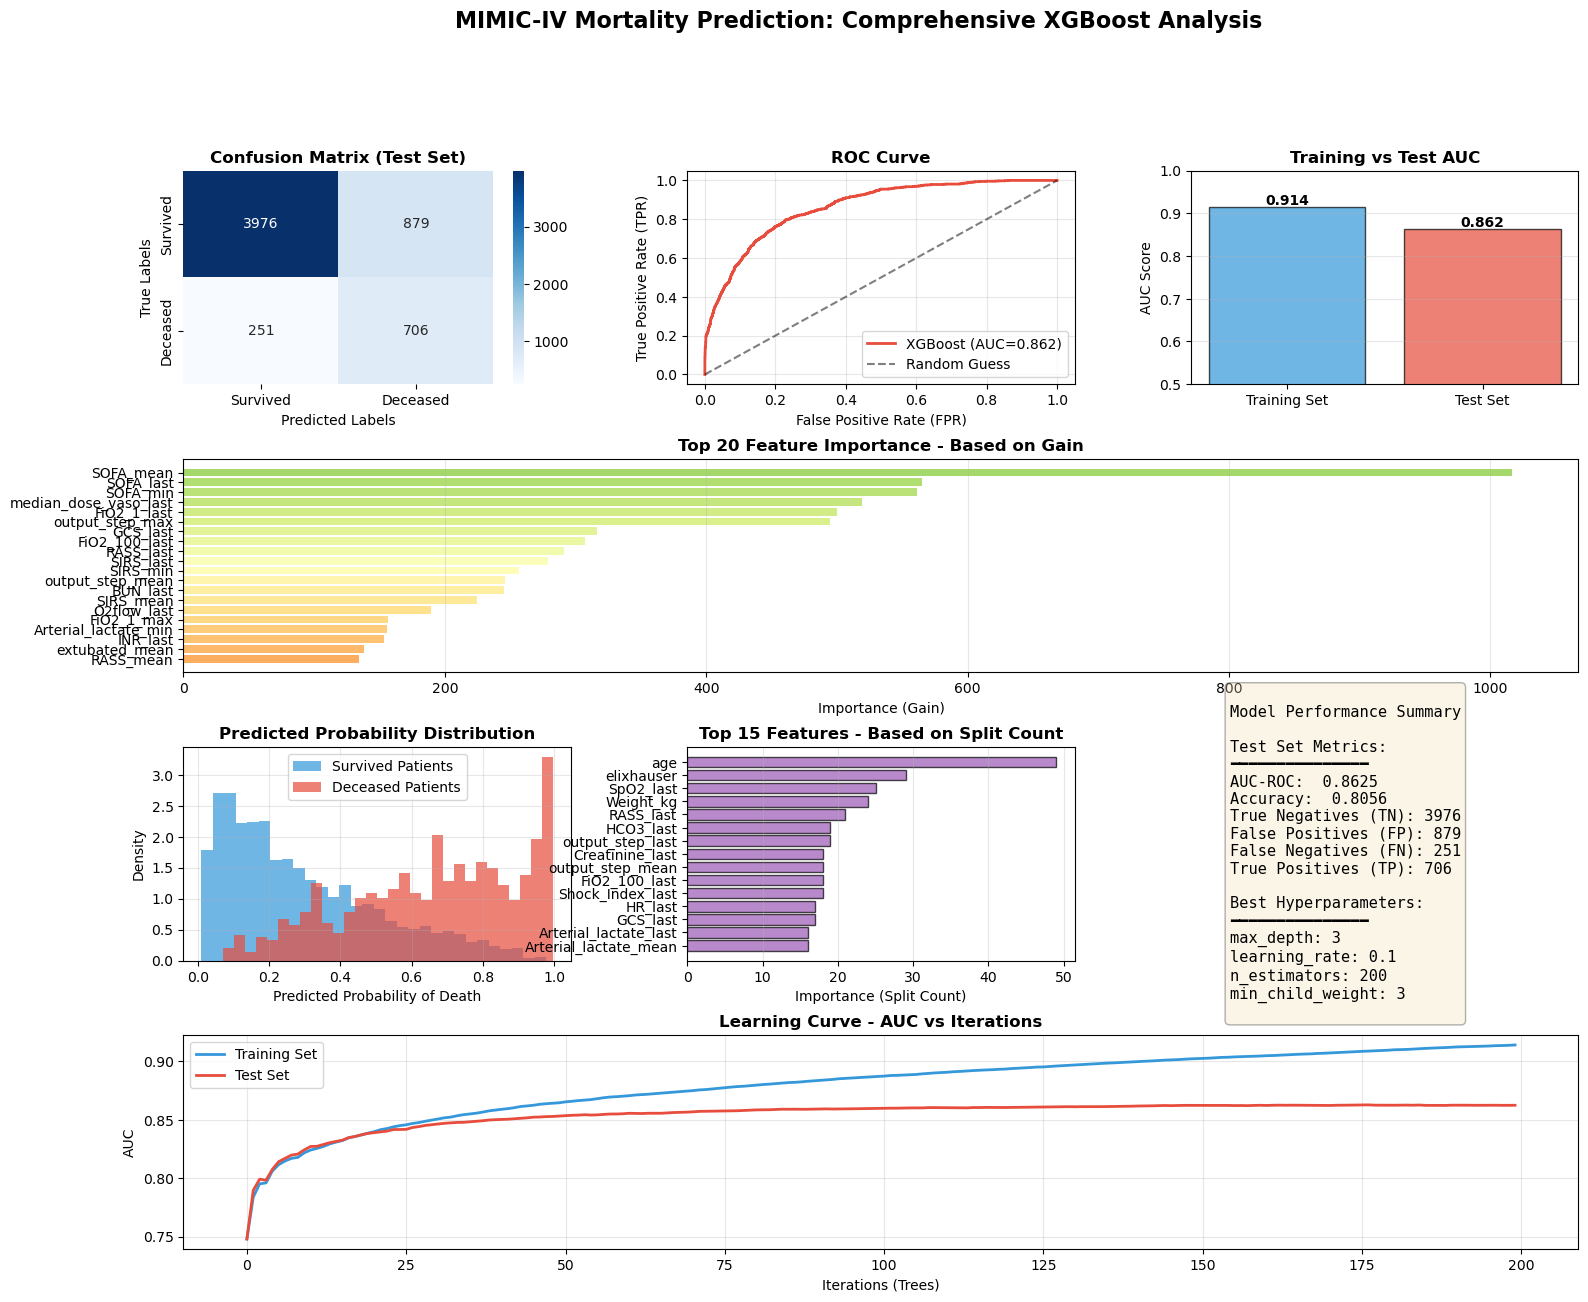

In [18]:
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Survived', 'Deceased'], 
            yticklabels=['Survived', 'Deceased'])
ax1.set_title('Confusion Matrix (Test Set)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted Labels')
ax1.set_ylabel('True Labels')

# 2. ROC Curve
ax2 = fig.add_subplot(gs[0, 1])
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
ax2.plot(fpr, tpr, label=f'XGBoost (AUC={test_auc:.3f})', 
         linewidth=2, color='#e74c3c')
ax2.plot([0, 1], [0, 1], 'k--', label='Random Guess', alpha=0.5)
ax2.set_xlabel('False Positive Rate (FPR)')
ax2.set_ylabel('True Positive Rate (TPR)')
ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Training vs Test AUC Comparison
ax3 = fig.add_subplot(gs[0, 2])
scores = [train_auc, test_auc]
labels = ['Training Set', 'Test Set']
colors = ['#3498db', '#e74c3c']
bars = ax3.bar(labels, scores, color=colors, alpha=0.7, edgecolor='black')
ax3.set_ylabel('AUC Score')
ax3.set_title('Training vs Test AUC', fontsize=12, fontweight='bold')
ax3.set_ylim([0.5, 1.0])
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Top 20 Feature Importance (Gain)
ax4 = fig.add_subplot(gs[1, :])
top20 = importance_df.head(20)
colors_feat = plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, len(top20)))
ax4.barh(range(len(top20)), top20['importance_gain'], color=colors_feat)
ax4.set_yticks(range(len(top20)))
ax4.set_yticklabels(top20['feature_name'])
ax4.set_xlabel('Importance (Gain)')
ax4.set_title('Top 20 Feature Importance - Based on Gain', 
              fontsize=12, fontweight='bold')
ax4.invert_yaxis()
ax4.grid(True, axis='x', alpha=0.3)

# 5. Predicted Probability Distribution
ax5 = fig.add_subplot(gs[2, 0])
ax5.hist(y_test_proba[y_test==0], bins=30, alpha=0.7, 
         label='Survived Patients', density=True, color='#3498db')
ax5.hist(y_test_proba[y_test==1], bins=30, alpha=0.7, 
         label='Deceased Patients', density=True, color='#e74c3c')
ax5.set_xlabel('Predicted Probability of Death')
ax5.set_ylabel('Density')
ax5.set_title('Predicted Probability Distribution', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Top 15 Feature Importance (Weight - Split Count)
ax6 = fig.add_subplot(gs[2, 1])
top15_weight = importance_weight_df.head(15)
ax6.barh(range(len(top15_weight)), top15_weight['importance_weight'], 
         color='#9b59b6', alpha=0.7, edgecolor='black')
ax6.set_yticks(range(len(top15_weight)))
ax6.set_yticklabels(top15_weight['feature_name'])
ax6.set_xlabel('Importance (Split Count)')
ax6.set_title('Top 15 Features - Based on Split Count', 
              fontsize=12, fontweight='bold')
ax6.invert_yaxis()
ax6.grid(True, axis='x', alpha=0.3)

# 7. Performance Metrics Summary
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')
metrics_text = f"""
Model Performance Summary

Test Set Metrics:
━━━━━━━━━━━━━━━
AUC-ROC:  {test_auc:.4f}
Accuracy:  {test_acc:.4f}
True Negatives (TN): {cm[0,0]}
False Positives (FP): {cm[0,1]}
False Negatives (FN): {cm[1,0]}
True Positives (TP): {cm[1,1]}

Best Hyperparameters:
━━━━━━━━━━━━━━━
max_depth: {best_params['max_depth']}
learning_rate: {best_params['learning_rate']}
n_estimators: {best_params['n_estimators']}
min_child_weight: {best_params['min_child_weight']}
"""
ax7.text(0.1, 0.5, metrics_text, fontsize=11, 
         verticalalignment='center', family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# 8. Learning Curve (if evals_result is available)
ax8 = fig.add_subplot(gs[3, :])
# Retrain to get learning curve
eval_set = [(X_train_imputed, y_train), (X_test_imputed, y_test)]
best_xgb_eval = xgb.XGBClassifier(**best_params)
best_xgb_eval.set_params(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    tree_method='hist',
    use_label_encoder=False
)
best_xgb_eval.fit(X_train_imputed, y_train, 
                  eval_set=eval_set, 
                  verbose=False)

results = best_xgb_eval.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
ax8.plot(x_axis, results['validation_0']['auc'], 
         label='Training Set', linewidth=2, color='#3498db')
ax8.plot(x_axis, results['validation_1']['auc'], 
         label='Test Set', linewidth=2, color='#e74c3c')
ax8.set_xlabel('Iterations (Trees)')
ax8.set_ylabel('AUC')
ax8.set_title('Learning Curve - AUC vs Iterations', fontsize=12, fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3)

plt.suptitle('MIMIC-IV Mortality Prediction: Comprehensive XGBoost Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()